Implementing A2C on CartPole environment. The target is the total return of an episode, leveraging Monte Carlo Methods.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

In [136]:
# Configs
hidden_dim = 256
lr = 3e-4
Gamma = 0.99
num_steps = 500
max_episodes = 3000

In [137]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, lr = lr):
        super(ActorCritic, self).__init__()
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.hidden_dim = hidden_dim
        self.lr = lr

        self.critic1 = nn.Linear(num_inputs, hidden_dim)
        self.critic2 = nn.Linear(hidden_dim, 1)

        self.actor1 = nn.Linear(num_inputs, hidden_dim)
        self.actor2 = nn.Linear(hidden_dim, num_actions)

    def forward(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        value = self.critic2(F.relu(self.critic1(state)))

        pi_dist = self.actor2(F.relu(self.actor1(state)))
        pi_dist = F.softmax(pi_dist)

        return value, pi_dist

In [142]:
def a2c(env, lr):
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    actor_critic = ActorCritic(num_inputs, num_actions, hidden_dim, lr)
    optimizer = optim.Adam(actor_critic.parameters(), lr = actor_critic.lr)

    all_rewards = []


    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, pi_dist = actor_critic.forward(state)
            value = value.detach().numpy().item()
            p = pi_dist.detach().numpy().squeeze()
            action = torch.multinomial(pi_dist, num_samples=1, replacement=True).item()

            log_prob = torch.log(pi_dist.squeeze(0)[action])
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            state = new_state

            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy().item()
                all_rewards.append(np.sum(rewards))
                if episode % 10 == 0 :
                  print(f"Episode {episode} completed with total reward: {np.sum(rewards)}")
                break

        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            if (t < len(rewards) - 1):
                Qval = rewards[t] + Gamma * Qval

            Qvals[t] = Qval

        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()

        critic_loss = 0.5 * advantage.pow(2).mean()

        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    win_size = 100
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [r for r in smoothed_rewards]
    plt.plot(all_rewards)
    smoothed_rewards = np.convolve(all_rewards, np.ones(win_size)/win_size, mode='valid')
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    return actor_critic

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
<ipython-input-137-72beaf93e763>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi_dist = F.softmax(pi_dist)


Episode 0 completed with total reward: 23.0
Episode 10 completed with total reward: 24.0
Episode 20 completed with total reward: 35.0
Episode 30 completed with total reward: 13.0
Episode 40 completed with total reward: 19.0
Episode 50 completed with total reward: 34.0
Episode 60 completed with total reward: 32.0
Episode 70 completed with total reward: 24.0
Episode 80 completed with total reward: 43.0
Episode 90 completed with total reward: 25.0
Episode 100 completed with total reward: 13.0
Episode 110 completed with total reward: 59.0
Episode 120 completed with total reward: 44.0
Episode 130 completed with total reward: 76.0
Episode 140 completed with total reward: 22.0
Episode 150 completed with total reward: 46.0
Episode 160 completed with total reward: 75.0
Episode 170 completed with total reward: 37.0
Episode 180 completed with total reward: 76.0
Episode 190 completed with total reward: 17.0
Episode 200 completed with total reward: 86.0
Episode 210 completed with total reward: 57.0

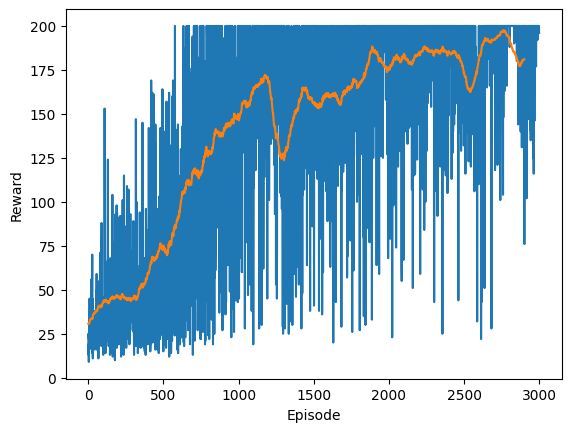

In [143]:
env = gym.make('CartPole-v0')
actor_critic_model = a2c(env, lr=lr)